#Setup

In [ ]:
!nvidia-smi

In [ ]:
!pip -qq install catboost

     |████████████████████████████████| 76.6 MB 1.1 MB/s 


# IMPORTS

In [ ]:
import random
import torch
import os
import numpy as np

SEED_VAL  = 1000
# Set the seed value all over the place to make this reproducible.
def seed_all(SEED):
  random.seed(SEED_VAL)
  np.random.seed(SEED_VAL)
  torch.manual_seed(SEED_VAL)
  torch.cuda.manual_seed_all(SEED_VAL)
  os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
  torch.backends.cudnn.deterministic = True
seed_all(SEED_VAL)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
from functools import reduce
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

# Loading the Data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/GeoAI/Train.csv')
print(train.shape)
train.head()

(1004, 1202)


,ID,Target,timestep1_B02_mean,timestep1_B03_mean,timestep1_B04_mean,timestep1_B05_mean,timestep1_B06_mean,timestep1_B07_mean,timestep1_B08_mean,timestep1_B8A_mean,...,timestep24_B02_min,timestep24_B03_min,timestep24_B04_min,timestep24_B05_min,timestep24_B06_min,timestep24_B07_min,timestep24_B08_min,timestep24_B8A_min,timestep24_B11_min,timestep24_B12_min
0,6fba03cb,olive+cereals,456.918182,799.361364,825.761364,1420.606818,2478.922727,2882.245455,3084.704545,1989.954545,...,113.0,562.0,206.0,1193.0,1497.0,1588.0,1644.0,2060.0,1157.0,1630.0
1,7ea60a74,plowing_and_sowing,1087.130208,1653.770833,2194.458333,2447.984375,2588.328125,2725.609375,2777.385417,3698.088542,...,328.0,913.0,746.0,1468.0,1523.0,1603.0,1782.0,2308.0,1429.0,1741.0
2,64d18595,olive,917.369369,1383.882883,1742.765766,2012.234234,2388.657658,2592.783784,2644.738739,3111.837838,...,113.0,587.0,312.0,1161.0,2050.0,2182.0,2238.0,2016.0,1134.0,2372.0
3,119c8ec4,arable_soil,1013.775120,1551.863636,2073.009569,2371.222488,2666.064593,2843.196172,2930.330144,3802.370813,...,212.0,592.0,810.0,1289.0,1655.0,1796.0,1824.0,2418.0,1708.0,1965.0
4,d884d98c,olive,801.352113,1243.741784,1557.410798,1827.133803,2248.718310,2433.793427,2471.901408,2846.659624,...,84.0,326.0,480.0,790.0,1132.0,1207.0,1194.0,1595.0,1085.0,1283.0


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/GeoAI/Test.csv')
print(test.shape)
test.head()

(502, 1201)


,ID,timestep1_B02_mean,timestep1_B03_mean,timestep1_B04_mean,timestep1_B05_mean,timestep1_B06_mean,timestep1_B07_mean,timestep1_B08_mean,timestep1_B8A_mean,timestep1_B11_mean,...,timestep24_B02_min,timestep24_B03_min,timestep24_B04_min,timestep24_B05_min,timestep24_B06_min,timestep24_B07_min,timestep24_B08_min,timestep24_B8A_min,timestep24_B11_min,timestep24_B12_min
0,d8da32b5,901.974359,1255.743590,1561.230769,1891.230769,2340.333333,2568.282051,2679.179487,3381.820513,2856.641026,...,345.0,631.0,763.0,1299.0,1803.0,1964.0,2050.0,2384.0,1901.0,2171.0
1,670ad0fb,927.181818,1423.636364,1778.636364,2161.477273,2745.909091,2969.204545,3063.000000,3632.977273,2942.500000,...,600.0,1048.0,1416.0,2014.0,2367.0,2574.0,2614.0,3160.0,2482.0,2795.0
2,fec40ac9,716.611940,1126.828358,1390.171642,1751.037313,2480.328358,2757.880597,2798.059701,2913.335821,2234.589552,...,228.0,525.0,723.0,1106.0,1514.0,1582.0,1742.0,2141.0,1453.0,1761.0
3,4f6d4495,565.611940,931.238806,999.813433,1558.462687,2627.276119,2965.738806,3134.194030,2584.865672,1740.194030,...,245.0,528.0,723.0,1140.0,1270.0,1420.0,1532.0,2270.0,1387.0,1613.0
4,e56d2db7,943.473430,1371.809179,1709.190821,1926.652174,2180.309179,2325.961353,2378.082126,2846.335749,2323.219807,...,415.0,840.0,1046.0,1417.0,1885.0,2017.0,2080.0,2375.0,1665.0,2157.0


In [ ]:
ss = pd.read_csv('/content/drive/MyDrive/GeoAI/SampleSubmission.csv')
print(ss.shape)
ss.head()

(502, 14)


,ID,arable_soil,cereals,forage_crop,greenhouses,mixed_crops,ochards,olive,olive+arbo,olive+cereals,olive+crops,plowing_and_sowing,vegetable_and_flower,wheat
0,d8da32b5,0,0,0,0,0,0,0,0,1,0,0,0,0
1,670ad0fb,0,0,0,0,0,0,0,0,0,0,1,0,0
2,fec40ac9,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4f6d4495,1,0,0,0,0,0,0,0,0,0,0,0,0
4,e56d2db7,0,0,0,0,0,0,0,1,0,0,0,0,0


# Data Processing

---



In [ ]:
def process(train,test,ss) :
  
  target_mapper = dict(zip(ss.drop('ID',1).columns.tolist(),
                          [i for i in range(len(ss.drop('ID',1).columns.tolist()))]))  # Used to Encode Train Target 
  train['Target'] = train['Target'].map(target_mapper)
  
  Inversetarget_mapper = dict(zip([i for i in range(len(ss.drop('ID',1).columns.tolist()))],
                                  ss.drop('ID',1).columns.tolist())) # Used to Create submission file 

  in_cols = train.filter(like='timestep').columns.tolist() # features used in Training, we will use only time step 1 in this tutorial

  return target_mapper , Inversetarget_mapper , in_cols , train , test , ss

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/GeoAI/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/GeoAI/Test.csv')
ss = pd.read_csv('/content/drive/MyDrive/GeoAI/SampleSubmission.csv')

target_mapper , Inversetarget_mapper , in_cols , train , test , ss  = process(train,test,ss)

## Combine train and test datasets for easy manipulation

In [ ]:
# Combining training and test data for easy manipulation
train_df, test_df, target_season = train.copy(), test.copy(), train.Target.copy()
splitter = train_df.shape[0]
comb = pd.concat([train_df, test_df], join = 'inner')
comb.head()

,ID,timestep1_B02_mean,timestep1_B03_mean,timestep1_B04_mean,timestep1_B05_mean,timestep1_B06_mean,timestep1_B07_mean,timestep1_B08_mean,timestep1_B8A_mean,timestep1_B11_mean,...,timestep24_B02_min,timestep24_B03_min,timestep24_B04_min,timestep24_B05_min,timestep24_B06_min,timestep24_B07_min,timestep24_B08_min,timestep24_B8A_min,timestep24_B11_min,timestep24_B12_min
0,6fba03cb,456.918182,799.361364,825.761364,1420.606818,2478.922727,2882.245455,3084.704545,1989.954545,1250.377273,...,113.0,562.0,206.0,1193.0,1497.0,1588.0,1644.0,2060.0,1157.0,1630.0
1,7ea60a74,1087.130208,1653.770833,2194.458333,2447.984375,2588.328125,2725.609375,2777.385417,3698.088542,2962.229167,...,328.0,913.0,746.0,1468.0,1523.0,1603.0,1782.0,2308.0,1429.0,1741.0
2,64d18595,917.369369,1383.882883,1742.765766,2012.234234,2388.657658,2592.783784,2644.738739,3111.837838,2456.693694,...,113.0,587.0,312.0,1161.0,2050.0,2182.0,2238.0,2016.0,1134.0,2372.0
3,119c8ec4,1013.775120,1551.863636,2073.009569,2371.222488,2666.064593,2843.196172,2930.330144,3802.370813,3152.626794,...,212.0,592.0,810.0,1289.0,1655.0,1796.0,1824.0,2418.0,1708.0,1965.0
4,d884d98c,801.352113,1243.741784,1557.410798,1827.133803,2248.718310,2433.793427,2471.901408,2846.659624,2175.328638,...,84.0,326.0,480.0,790.0,1132.0,1207.0,1194.0,1595.0,1085.0,1283.0


In [ ]:
comb.shape

(1506, 1201)

In [ ]:
comb.drop('ID',axis=1,inplace=True)

## Remove Skewness

In [ ]:
# Remove skewness by using square root
comb = comb**(1/2.0)
comb.head()

,timestep1_B02_mean,timestep1_B03_mean,timestep1_B04_mean,timestep1_B05_mean,timestep1_B06_mean,timestep1_B07_mean,timestep1_B08_mean,timestep1_B8A_mean,timestep1_B11_mean,timestep1_B12_mean,...,timestep24_B02_min,timestep24_B03_min,timestep24_B04_min,timestep24_B05_min,timestep24_B06_min,timestep24_B07_min,timestep24_B08_min,timestep24_B8A_min,timestep24_B11_min,timestep24_B12_min
0,21.375645,28.272979,28.736064,37.690938,49.788781,53.686548,55.540117,44.608907,35.360674,56.231037,...,10.630146,23.706539,14.352700,34.539832,38.691084,39.849718,40.546270,45.387223,34.014703,40.373258
1,32.971658,40.666581,46.845046,49.477110,50.875614,52.207369,52.700905,60.811911,54.426365,52.929149,...,18.110770,30.215890,27.313001,38.314488,39.025633,40.037482,42.213742,48.041649,37.802116,41.725292
2,30.288106,37.200576,41.746446,44.857934,48.873895,50.919385,51.427023,55.783849,49.565045,52.013339,...,10.630146,24.228083,17.663522,34.073450,45.276926,46.711883,47.307505,44.899889,33.674916,48.703183
3,31.839835,39.393700,45.530315,48.695200,51.633948,53.321629,54.132524,61.663367,56.148257,54.375775,...,14.560220,24.331050,28.460499,35.902646,40.681691,42.379240,42.708313,49.173163,41.327957,44.328321
4,28.308163,35.266723,39.464044,42.744986,47.420653,49.333492,49.718220,53.354097,46.640419,49.870442,...,9.165151,18.055470,21.908902,28.106939,33.645208,34.741906,34.554305,39.937451,32.939338,35.818989


## Vegetation Index Calculation

In [ ]:
# Calculation of vegetation indices
def vegetation_index_mean(i):
  b02 = comb.filter(like = "timestep"+str(i)+"_B02_mean").values
  b03 = comb.filter(like = "timestep"+str(i)+"_B03_mean").values
  b04 = comb.filter(like = "timestep"+str(i)+"_B04_mean").values
  b05 = comb.filter(like = "timestep"+str(i)+"_B05_mean").values
  b06 = comb.filter(like = "timestep"+str(i)+"_B06_mean").values
  b07 = comb.filter(like = "timestep"+str(i)+"_B07_mean").values
  b08 = comb.filter(like = "timestep"+str(i)+"_B08_mean").values
  b8a = comb.filter(like = "timestep"+str(i)+"_B8A_mean").values
  b09 = comb.filter(like = "timestep"+str(i)+"_B09_mean").values   
  b11 = comb.filter(like = "timestep"+str(i)+"_B11_mean").values
  b12 = comb.filter(like = "timestep"+str(i)+"_B12_mean").values

  # WHEAT
  MI = (b8a - b11) / (b8a + b11)
  ARVI =  (b08 - (2 * b04) + b02) / (b08 + (2 * b04) + b02)
  SIPI = (b08 - b02) / (b08 - b04)
  RENDVI = (b06 - b05) / (b06 + b05) 

  RYI = b03 / b02
  NDYI = (b03 - b02) / (b03 + b02)
  DYI = b03 - b02
  ACI = b08 * (b04 + b03)

  CVI = (b08 / b03) * (b04 / b03)
  AVI = (b08 * (1 - b04) * (b08 - b04))
  SI = ((1 - b02) * (1 - b03) * (1 - b04))
  BSI = ((b11 + b04) - (b08 + b02)) / ((b11 + b04) + (b08 + b02))

  # SOIL
  SAVI = ((b08 - b04)/(b08 + b04 + 0.33)) * (1 + 0.33)

  FIDET = b12 / (b8a * b09)
  MTCI = (b06 - b05)/(b05 - b04)
  NPCRI = (b04 - b02) / (b04 + b02)

  # GREENNESS
  S2REP = 705 + 35 * ((((b07 + b04)/2) - b05)/(b06 - b05)) 
  CCCI = ((b08 - b05) / (b08 + b05)) / ((b08 - b04) / (b08 + b04)) 
  MCARI = ((b05 - b04) - 2 * (b05 - b03)) * (b05 / b04)  
  TCARI = 3 * ((b05 - b04) - 0.2 * (b05 - b03) * (b05 / b04)) 
  PVI = (b08 - 0.3 * b04 - 0.5) / ((1 + 0.3 * 2) ** (1/2.0)) 
  EVI = 2.5*(b08 - b04) / (b08 + 6*b04 - 7.5*b02 + 1) 
  NDVI = ((b08 - b04)/(b08 + b04))

  # ROOIBOS
  BAI = 1/((0.1 - b04) ** 2 + (0.06 - b08) ** 2)
  MTVI2 = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2-(6 * i - 5 * k ** (1/2.0)) - 0.5)**(1/2.0) for i, j, k in zip(b08, b03, b04))
  NDSI = (b03 - b11) / (b03 + b11)

  # RED EDGE
  NDVIre = (b08 - b05)/(b08 + b05)
  CIre = ((b08 / b05) - 1)

  # DRYNESS / DROUGHT
  NDMI = (b08 - b11)/(b08 + b11) 
  TNDVI = [(x)**(1/2.0) for x in ((b08 - b04) / (b08 + b04) + 0.5)]

  # BASED ON THE VISIBLE SPECTRA REGION
  VDVI = (2 * b03 - b04 - b02) / (2 * b03 + b04  + b02) 

  # BURN
  NBR = (b08 - b11) / (b08+ b11) 

  # GENERAL
  TVI = (120 * (b06 - b03) - 200 * (b04 - b03)) / 2
  EXG = 2 * b03 - b04 - b02
  PSRI = (b04 - b02) / b06
  RDVI = [(i - j) / (i + j)**(1/2.0) for i, j in zip(b08, b04)]

  # COMMON BAND RATIOS
  RATIO3 = b11 / b12
  RATIO4 = b05 / b04

  return [MI, ARVI, SIPI, RENDVI, RYI, NDYI, DYI, ACI, CVI, AVI, SI, BSI, SAVI, FIDET, MTCI, NPCRI, S2REP, CCCI,\
          MCARI, TCARI, PVI, EVI, NDVI, BAI, MTVI2, NDSI,  NDVIre, CIre, NDMI, TNDVI, VDVI, NBR, TVI, EXG, PSRI, RDVI, \
          RATIO3, RATIO4]


In [ ]:
# Calculation of vegetation indices
def vegetation_index_min(i):
  b02 = comb.filter(like = "timestep"+str(i)+"_B02_min").values
  b03 = comb.filter(like = "timestep"+str(i)+"_B03_min").values
  b04 = comb.filter(like = "timestep"+str(i)+"_B04_min").values
  b05 = comb.filter(like = "timestep"+str(i)+"_B05_min").values
  b06 = comb.filter(like = "timestep"+str(i)+"_B06_min").values
  b07 = comb.filter(like = "timestep"+str(i)+"_B07_min").values
  b08 = comb.filter(like = "timestep"+str(i)+"_B08_min").values
  b8a = comb.filter(like = "timestep"+str(i)+"_B8A_min").values
  b09 = comb.filter(like = "timestep"+str(i)+"_B09_min").values   
  b11 = comb.filter(like = "timestep"+str(i)+"_B11_min").values
  b12 = comb.filter(like = "timestep"+str(i)+"_B12_min").values

  # WHEAT
  MI = (b8a - b11) / (b8a + b11)
  ARVI =  (b08 - (2 * b04) + b02) / (b08 + (2 * b04) + b02)
  SIPI = (b08 - b02) / (b08 - b04)
  RENDVI = (b06 - b05) / (b06 + b05) 

  RYI = b03 / b02
  NDYI = (b03 - b02) / (b03 + b02)
  DYI = b03 - b02
  ACI = b08 * (b04 + b03)

  
  CVI = (b08 / b03) * (b04 / b03)
  AVI = (b08 * (1 - b04) * (b08 - b04))
  SI = ((1 - b02) * (1 - b03) * (1 - b04))
  BSI = ((b11 + b04) - (b08 + b02)) / ((b11 + b04) + (b08 + b02))

  # SOIL
  SAVI = ((b08 - b04)/(b08 + b04 + 0.33)) * (1 + 0.33)

  FIDET = b12 / (b8a * b09)
  MTCI = (b06 - b05)/(b05 - b04)
  NPCRI = (b04 - b02) / (b04 + b02)

  # GREENNESS
  S2REP = 705 + 35 * ((((b07 + b04)/2) - b05)/(b06 - b05)) 
  CCCI = ((b08 - b05) / (b08 + b05)) / ((b08 - b04) / (b08 + b04)) 
  MCARI = ((b05 - b04) - 2 * (b05 - b03)) * (b05 / b04)  
  TCARI = 3 * ((b05 - b04) - 0.2 * (b05 - b03) * (b05 / b04)) 
  PVI = (b08 - 0.3 * b04 - 0.5) / ((1 + 0.3 * 2) ** (1/2.0)) 
  EVI = 2.5*(b08 - b04) / (b08 + 6*b04 - 7.5*b02 + 1) 
  NDVI = ((b08 - b04)/(b08 + b04))

  # ROOIBOS
  BAI = 1/((0.1 - b04) ** 2 + (0.06 - b08) ** 2)
  MTVI2 = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2-(6 * i - 5 * k ** (1/2.0)) - 0.5)**(1/2.0) for i, j, k in zip(b08, b03, b04))
  NDSI = (b03 - b11) / (b03 + b11)

  # RED EDGE
  NDVIre = (b08 - b05)/(b08 + b05)
  CIre = ((b08 / b05) - 1)

  # DRYNESS / DROUGHT
  NDMI = (b08 - b11)/(b08 + b11) 
  TNDVI = [(x)**(1/2.0) for x in ((b08 - b04) / (b08 + b04) + 0.5)]

  # BASED ON THE VISIBLE SPECTRA REGION
  VDVI = (2 * b03 - b04 - b02) / (2 * b03 + b04  + b02) 

  # BURN
  NBR = (b08 - b11) / (b08+ b11) 

  # GENERAL
  TVI = (120 * (b06 - b03) - 200 * (b04 - b03)) / 2
  EXG = 2 * b03 - b04 - b02
  PSRI = (b04 - b02) / b06
  RDVI = [(i - j) / (i + j)**(1/2.0) for i, j in zip(b08, b04)]

  # COMMON BAND RATIOS
  RATIO3 = b11 / b12
  RATIO4 = b05 / b04

  return [MI, ARVI, SIPI, RENDVI, RYI, NDYI, DYI, ACI, CVI, AVI, SI, BSI, SAVI, FIDET, MTCI, NPCRI, S2REP, CCCI,\
          MCARI, TCARI, PVI, EVI, NDVI, BAI, MTVI2, NDSI,  NDVIre, CIre, NDMI, TNDVI, VDVI, NBR, TVI, EXG, PSRI, RDVI, \
          RATIO3, RATIO4]


In [ ]:
# Calculation of vegetation indices
def vegetation_index_median(i):
  b02 = comb.filter(like = "timestep"+str(i)+"_B02_median").values
  b03 = comb.filter(like = "timestep"+str(i)+"_B03_median").values
  b04 = comb.filter(like = "timestep"+str(i)+"_B04_median").values
  b05 = comb.filter(like = "timestep"+str(i)+"_B05_median").values
  b06 = comb.filter(like = "timestep"+str(i)+"_B06_median").values
  b07 = comb.filter(like = "timestep"+str(i)+"_B07_median").values
  b08 = comb.filter(like = "timestep"+str(i)+"_B08_median").values
  b8a = comb.filter(like = "timestep"+str(i)+"_B8A_median").values
  b09 = comb.filter(like = "timestep"+str(i)+"_B09_median").values   
  b11 = comb.filter(like = "timestep"+str(i)+"_B11_median").values
  b12 = comb.filter(like = "timestep"+str(i)+"_B12_median").values

  # WHEAT
  MI = (b8a - b11) / (b8a + b11)
  ARVI =  (b08 - (2 * b04) + b02) / (b08 + (2 * b04) + b02)
  SIPI = (b08 - b02) / (b08 - b04)
  RENDVI = (b06 - b05) / (b06 + b05) 

  
  RYI = b03 / b02
  NDYI = (b03 - b02) / (b03 + b02)
  DYI = b03 - b02
  ACI = b08 * (b04 + b03)

  CVI = (b08 / b03) * (b04 / b03)
  AVI = (b08 * (1 - b04) * (b08 - b04))
  SI = ((1 - b02) * (1 - b03) * (1 - b04))
  BSI = ((b11 + b04) - (b08 + b02)) / ((b11 + b04) + (b08 + b02))

  # SOIL
  SAVI = ((b08 - b04)/(b08 + b04 + 0.33)) * (1 + 0.33)

  FIDET = b12 / (b8a * b09)
  MTCI = (b06 - b05)/(b05 - b04)
  NPCRI = (b04 - b02) / (b04 + b02)

  # GREENNESS
  S2REP = 705 + 35 * ((((b07 + b04)/2) - b05)/(b06 - b05)) 
  CCCI = ((b08 - b05) / (b08 + b05)) / ((b08 - b04) / (b08 + b04)) 
  MCARI = ((b05 - b04) - 2 * (b05 - b03)) * (b05 / b04)  
  TCARI = 3 * ((b05 - b04) - 0.2 * (b05 - b03) * (b05 / b04)) 
  PVI = (b08 - 0.3 * b04 - 0.5) / ((1 + 0.3 * 2) ** (1/2.0)) 
  EVI = 2.5*(b08 - b04) / (b08 + 6*b04 - 7.5*b02 + 1) 
  NDVI = ((b08 - b04)/(b08 + b04))

  # ROOIBOS
  BAI = 1/((0.1 - b04) ** 2 + (0.06 - b08) ** 2)
  MTVI2 = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2-(6 * i - 5 * k ** (1/2.0)) - 0.5)**(1/2.0) for i, j, k in zip(b08, b03, b04))
  NDSI = (b03 - b11) / (b03 + b11)

  # RED EDGE
  NDVIre = (b08 - b05)/(b08 + b05)
  CIre = ((b08 / b05) - 1)

  # DRYNESS / DROUGHT
  NDMI = (b08 - b11)/(b08 + b11) 
  TNDVI = [(x)**(1/2.0) for x in ((b08 - b04) / (b08 + b04) + 0.5)]

  # BASED ON THE VISIBLE SPECTRA REGION
  VDVI = (2 * b03 - b04 - b02) / (2 * b03 + b04  + b02) 

  # BURN
  NBR = (b08 - b11) / (b08+ b11) 

  # GENERAL
  TVI = (120 * (b06 - b03) - 200 * (b04 - b03)) / 2
  EXG = 2 * b03 - b04 - b02
  PSRI = (b04 - b02) / b06
  RDVI = [(i - j) / (i + j)**(1/2.0) for i, j in zip(b08, b04)]

  # COMMON BAND RATIOS
  RATIO3 = b11 / b12
  RATIO4 = b05 / b04

  return [MI, ARVI, SIPI, RENDVI, RYI, NDYI, DYI, ACI, CVI, AVI, SI, BSI, SAVI, FIDET, MTCI, NPCRI, S2REP, CCCI,\
          MCARI, TCARI, PVI, EVI, NDVI, BAI, MTVI2, NDSI,  NDVIre, CIre, NDMI, TNDVI, VDVI, NBR, TVI, EXG, PSRI, RDVI, \
          RATIO3, RATIO4]


In [ ]:
# Calculation of vegetation indices
def vegetation_index_max(i):
  
  b02 = comb.filter(like = "timestep"+str(i)+"_B02_max").values
  b03 = comb.filter(like = "timestep"+str(i)+"_B03_max").values
  b04 = comb.filter(like = "timestep"+str(i)+"_B04_max").values
  b05 = comb.filter(like = "timestep"+str(i)+"_B05_max").values
  b06 = comb.filter(like = "timestep"+str(i)+"_B06_max").values
  b07 = comb.filter(like = "timestep"+str(i)+"_B07_max").values
  b08 = comb.filter(like = "timestep"+str(i)+"_B08_max").values
  b8a = comb.filter(like = "timestep"+str(i)+"_B8A_max").values
  b09 = comb.filter(like = "timestep"+str(i)+"_B09_max").values   
  b11 = comb.filter(like = "timestep"+str(i)+"_B11_max").values
  b12 = comb.filter(like = "timestep"+str(i)+"_B12_max").values

  # WHEAT
  MI = (b8a - b11) / (b8a + b11)
  ARVI =  (b08 - (2 * b04) + b02) / (b08 + (2 * b04) + b02)
  SIPI = (b08 - b02) / (b08 - b04)
  RENDVI = (b06 - b05) / (b06 + b05) 
  

  RYI = b03 / b02
  NDYI = (b03 - b02) / (b03 + b02)
  DYI = b03 - b02
  ACI = b08 * (b04 + b03)

  CVI = (b08 / b03) * (b04 / b03)
  AVI = (b08 * (1 - b04) * (b08 - b04))
  SI = ((1 - b02) * (1 - b03) * (1 - b04))
  BSI = ((b11 + b04) - (b08 + b02)) / ((b11 + b04) + (b08 + b02))

  # SOIL
  SAVI = ((b08 - b04)/(b08 + b04 + 0.33)) * (1 + 0.33)

  FIDET = b12 / (b8a * b09)
  MTCI = (b06 - b05)/(b05 - b04)
  NPCRI = (b04 - b02) / (b04 + b02)

  # GREENNESS
  S2REP = 705 + 35 * ((((b07 + b04)/2) - b05)/(b06 - b05)) 
  CCCI = ((b08 - b05) / (b08 + b05)) / ((b08 - b04) / (b08 + b04)) 
  MCARI = ((b05 - b04) - 2 * (b05 - b03)) * (b05 / b04)  
  TCARI = 3 * ((b05 - b04) - 0.2 * (b05 - b03) * (b05 / b04)) 
  PVI = (b08 - 0.3 * b04 - 0.5) / ((1 + 0.3 * 2) ** (1/2.0)) 
  EVI = 2.5*(b08 - b04) / (b08 + 6*b04 - 7.5*b02 + 1) 
  NDVI = ((b08 - b04)/(b08 + b04))

  # ROOIBOS
  BAI = 1/((0.1 - b04) ** 2 + (0.06 - b08) ** 2)
  MTVI2 = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2-(6 * i - 5 * k ** (1/2.0)) - 0.5)**(1/2.0) for i, j, k in zip(b08, b03, b04))
  NDSI = (b03 - b11) / (b03 + b11)

  # RED EDGE
  NDVIre = (b08 - b05)/(b08 + b05)
  CIre = ((b08 / b05) - 1)

  # DRYNESS / DROUGHT
  NDMI = (b08 - b11)/(b08 + b11) 
  TNDVI = [(x)**(1/2.0) for x in ((b08 - b04) / (b08 + b04) + 0.5)]

  # BASED ON THE VISIBLE SPECTRA REGION
  VDVI = (2 * b03 - b04 - b02) / (2 * b03 + b04  + b02) 

  # BURN
  NBR = (b08 - b11) / (b08+ b11) 

  # GENERAL
  TVI = (120 * (b06 - b03) - 200 * (b04 - b03)) / 2
  EXG = 2 * b03 - b04 - b02
  PSRI = (b04 - b02) / b06
  RDVI = [(i - j) / (i + j)**(1/2.0) for i, j in zip(b08, b04)]

  # COMMON BAND RATIOS
  RATIO3 = b11 / b12
  RATIO4 = b05 / b04

  return [MI, ARVI, SIPI, RENDVI, RYI, NDYI, DYI, ACI, CVI, AVI, SI, BSI, SAVI, FIDET, MTCI, NPCRI, S2REP, CCCI,\
          MCARI, TCARI, PVI, EVI, NDVI, BAI, MTVI2, NDSI,  NDVIre, CIre, NDMI, TNDVI, VDVI, NBR, TVI, EXG, PSRI, RDVI, \
          RATIO3, RATIO4]


In [ ]:
# Calculation of vegetation indices
def vegetation_index_std(i):
  b02 = comb.filter(like = "timestep"+str(i)+"_B02_std").values
  b03 = comb.filter(like = "timestep"+str(i)+"_B03_std").values
  b04 = comb.filter(like = "timestep"+str(i)+"_B04_std").values
  b05 = comb.filter(like = "timestep"+str(i)+"_B05_std").values
  b06 = comb.filter(like = "timestep"+str(i)+"_B06_std").values
  b07 = comb.filter(like = "timestep"+str(i)+"_B07_std").values
  b08 = comb.filter(like = "timestep"+str(i)+"_B08_std").values
  b8a = comb.filter(like = "timestep"+str(i)+"_B8A_std").values
  b09 = comb.filter(like = "timestep"+str(i)+"_B09_std").values   
  b11 = comb.filter(like = "timestep"+str(i)+"_B11_std").values
  b12 = comb.filter(like = "timestep"+str(i)+"_B12_std").values

  # WHEAT
  MI = (b8a - b11) / (b8a + b11)
  ARVI =  (b08 - (2 * b04) + b02) / (b08 + (2 * b04) + b02)
  SIPI = (b08 - b02) / (b08 - b04)
  RENDVI = (b06 - b05) / (b06 + b05) 

  # CANOLA
  RYI = b03 / b02
  NDYI = (b03 - b02) / (b03 + b02)
  DYI = b03 - b02
  ACI = b08 * (b04 + b03)

  # WEED
  CVI = (b08 / b03) * (b04 / b03)
  AVI = (b08 * (1 - b04) * (b08 - b04))
  SI = ((1 - b02) * (1 - b03) * (1 - b04))
  BSI = ((b11 + b04) - (b08 + b02)) / ((b11 + b04) + (b08 + b02))

  # SOIL
  SAVI = ((b08 - b04)/(b08 + b04 + 0.33)) * (1 + 0.33)

  # WINE GRAPES
  FIDET = b12 / (b8a * b09)
  MTCI = (b06 - b05)/(b05 - b04)
  NPCRI = (b04 - b02) / (b04 + b02)

  # GREENNESS
  S2REP = 705 + 35 * ((((b07 + b04)/2) - b05)/(b06 - b05)) 
  CCCI = ((b08 - b05) / (b08 + b05)) / ((b08 - b04) / (b08 + b04)) 
  MCARI = ((b05 - b04) - 2 * (b05 - b03)) * (b05 / b04)  
  TCARI = 3 * ((b05 - b04) - 0.2 * (b05 - b03) * (b05 / b04)) 
  PVI = (b08 - 0.3 * b04 - 0.5) / ((1 + 0.3 * 2) ** (1/2.0)) 
  EVI = 2.5*(b08 - b04) / (b08 + 6*b04 - 7.5*b02 + 1) 
  NDVI = ((b08 - b04)/(b08 + b04))

  # ROOIBOS
  BAI = 1/((0.1 - b04) ** 2 + (0.06 - b08) ** 2)
  MTVI2 = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2-(6 * i - 5 * k ** (1/2.0)) - 0.5)**(1/2.0) for i, j, k in zip(b08, b03, b04))
  NDSI = (b03 - b11) / (b03 + b11)

  # RED EDGE
  NDVIre = (b08 - b05)/(b08 + b05)
  CIre = ((b08 / b05) - 1)

  # DRYNESS / DROUGHT
  NDMI = (b08 - b11)/(b08 + b11) 
  TNDVI = [(x)**(1/2.0) for x in ((b08 - b04) / (b08 + b04) + 0.5)]

  # BASED ON THE VISIBLE SPECTRA REGION
  VDVI = (2 * b03 - b04 - b02) / (2 * b03 + b04  + b02) 

  # BURN
  NBR = (b08 - b11) / (b08+ b11) 

  # GENERAL
  TVI = (120 * (b06 - b03) - 200 * (b04 - b03)) / 2
  EXG = 2 * b03 - b04 - b02
  PSRI = (b04 - b02) / b06
  RDVI = [(i - j) / (i + j)**(1/2.0) for i, j in zip(b08, b04)]

  # COMMON BAND RATIOS
  RATIO3 = b11 / b12
  RATIO4 = b05 / b04

  return [MI, ARVI, SIPI, RENDVI, RYI, NDYI, DYI, ACI, CVI, AVI, SI, BSI, SAVI, FIDET, MTCI, NPCRI, S2REP, CCCI,\
          MCARI, TCARI, PVI, EVI, NDVI, BAI, MTVI2, NDSI,  NDVIre, CIre, NDMI, TNDVI, VDVI, NBR, TVI, EXG, PSRI, RDVI, \
          RATIO3, RATIO4]


In [ ]:
spectral_indices = ['MI', 'ARVI', 'SIPI', 'RENDVI', 'RYI', 'NDYI', 'DYI', 'ACI', 'CVI', 'AVI', 'SI', 'BSI',
                    'SAVI', 'FIDET', 'MTCI', 'NPCRI', 'S2REP', 'CCCI', 'MCARI', 'TCARI', 'PVI', 'EVI', 'NDVI', 'BAI', 'MTVI2', 'NDSI',
                    'NDVIre', 'CIre', 'NDMI', 'TNDVI', 'VDVI', 'NBR', 'TVI', 'EXG', 'PSRI', 'RDVI', 'RATIO3', 'RATIO4']

# Parallel processing to speed up the calculation of the vegetation indices
vegs_mean = Parallel(n_jobs=-1, verbose=2, backend="multiprocessing")(map(delayed(vegetation_index_mean), [x for x in range(1,25)]))
vegs_min = Parallel(n_jobs=-1, verbose=2, backend="multiprocessing")(map(delayed(vegetation_index_min), [x for x in range(1,25)]))
vegs_median = Parallel(n_jobs=-1, verbose=2, backend="multiprocessing")(map(delayed(vegetation_index_median), [x for x in range(1,25)]))
vegs_max = Parallel(n_jobs=-1, verbose=2, backend="multiprocessing")(map(delayed(vegetation_index_max), [x for x in range(1,25)]))
vegs_std = Parallel(n_jobs=-1, verbose=2, backend="multiprocessing")(map(delayed(vegetation_index_std), [x for x in range(1,25)]))


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    4.6s finished


In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [ ]:
# Adding the calculated indices to the combined dataframe
vi_df = pd.DataFrame()
for key,veg in {"mean":vegs_mean,"min":vegs_min,"median":vegs_median,"max":vegs_max,"std":vegs_std}.items():    
    for i in tqdm_notebook(range(24)):
      for n, m in zip(spectral_indices, veg[i]):
        
        try:
          vi_df['timestep'+str(i+1)+'_'+key+'_' + n] = m.tolist()
        except:
          vi_df['timestep'+str(i+1)+'_'+key+'_' + n] = m

    # Previewing the head of the engineered dataframe
vi_df.head()   

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

,timestep1_mean_MI,timestep1_mean_ARVI,timestep1_mean_SIPI,timestep1_mean_RENDVI,timestep1_mean_RYI,timestep1_mean_NDYI,timestep1_mean_DYI,timestep1_mean_ACI,timestep1_mean_CVI,timestep1_mean_AVI,...,timestep24_std_NDMI,timestep24_std_TNDVI,timestep24_std_VDVI,timestep24_std_NBR,timestep24_std_TVI,timestep24_std_EXG,timestep24_std_PSRI,timestep24_std_RDVI,timestep24_std_RATIO3,timestep24_std_RATIO4
0,[0.11564687965840562],[0.1446829300030343],[1.2746009828109426],[0.13829311632172603],[1.3226725990063728],[0.13892297999486045],[6.897334796651794],[3166.288903633663],[1.9965992927482894],[-41290.68408755856],...,[0.12020495049774056],[0.8073021042771662],[-0.0328245581160827],[0.12020495049774056],[22.63117857636513],[-2.012406504412347],[0.2872120295540863],[1.0160287480297072],[0.837597340524354],[0.8837899295186697]
1,[0.05541168079029316],[-0.04470010241931467],[3.3691464648877343],[0.01393589119303396],[1.233379944467552],[0.10449630169092915],[7.694923631871639],[4611.941979051628],[1.49281646600288],[-14148.19772398109],...,[0.34718579708101727],[0.875144902830549],[-0.05727988179266246],[0.34718579708101727],[338.0353049405161],[-2.700867835542354],[0.19273283895773521],[1.6793766835456718],[0.5242352380327533],[0.7452126830201454]
2,[0.05903055951680727],[-0.01076075345293324],[2.183642229062579],[0.042845227542059425],[1.228223920344856],[0.10242414070733716],[6.912470307349057],[4060.0103769549546],[1.551356325406719],[-20285.34418367693],...,[0.23821276864590962],[0.8124995393124884],[-0.10238068438400363],[0.23821276864590962],[-57.518372036972664],[-6.33468611240197],[0.27688886541163427],[1.114320823568863],[0.6797646572320226],[0.7008099981579184]
3,[0.046812949396449074],[-0.028741933292974968],[2.591507405356177],[0.029291071290216845],[1.2372457314859624],[0.10604366259239013],[7.55386504477649],[4597.151287986079],[1.588200662973909],[-20735.954676845664],...,[-0.0661287343595893],[0.675960214288544],[0.0064931493520795054],[-0.0661287343595893],[-164.20278462709965],[0.41577753650244453],[0.29224621340228224],[-0.25601678580344334],[1.1324616389193825],[0.9711464299557251]
4,[0.06714046354971304],[-0.00574501182903807],[2.087935424987086],[0.051856418394168866],[1.245814609049029],[0.10945454182129355],[6.958560108624905],[3715.4807624745868],[1.5775638228762603],[-19609.71467480297],...,[0.18983787454756776],[0.8285499493622912],[0.020507958148349107],[0.18983787454756776],[196.02423033065978],[0.9713569093090406],[0.1769590718009032],[1.0586765452756608],[0.6877132772860121],[0.9919957933052628]


In [ ]:
for col in vi_df.columns:
  print(col)
  if flatten(vi_df[col].values)==[]:
    vi_df.drop(col,axis=1,inplace=True)
  else:
    vi_df[col]=flatten(vi_df[col].values)

timestep1_mean_MI
timestep1_mean_ARVI
timestep1_mean_SIPI
timestep1_mean_RENDVI
timestep1_mean_RYI
timestep1_mean_NDYI
timestep1_mean_DYI
timestep1_mean_ACI
timestep1_mean_CVI
timestep1_mean_AVI
timestep1_mean_SI
timestep1_mean_BSI
timestep1_mean_SAVI
timestep1_mean_FIDET
timestep1_mean_MTCI
timestep1_mean_NPCRI
timestep1_mean_S2REP
timestep1_mean_CCCI
timestep1_mean_MCARI
timestep1_mean_TCARI
timestep1_mean_PVI
timestep1_mean_EVI
timestep1_mean_NDVI
timestep1_mean_BAI
timestep1_mean_MTVI2
timestep1_mean_NDSI
timestep1_mean_NDVIre
timestep1_mean_CIre
timestep1_mean_NDMI
timestep1_mean_TNDVI
timestep1_mean_VDVI
timestep1_mean_NBR
timestep1_mean_TVI
timestep1_mean_EXG
timestep1_mean_PSRI
timestep1_mean_RDVI
timestep1_mean_RATIO3
timestep1_mean_RATIO4
timestep2_mean_MI
timestep2_mean_ARVI
timestep2_mean_SIPI
timestep2_mean_RENDVI
timestep2_mean_RYI
timestep2_mean_NDYI
timestep2_mean_DYI
timestep2_mean_ACI
timestep2_mean_CVI
timestep2_mean_AVI
timestep2_mean_SI
timestep2_mean_BSI
timestep2

In [ ]:
# Calculate mean indices
def aggregator(ix):
  df = pd.Series(vi_df[[x for x in vi_df.columns if x.split('_')[-1] == ix]].mean(axis = 1)).to_frame()
  df.columns = [ix + '_' + 'MEAN']
  return df

for ix in tqdm_notebook(spectral_indices):
  vi_df = vi_df.merge(aggregator(ix), how = 'left', left_index=True, right_index=True)

vi_df.head()

  0%|          | 0/38 [00:00<?, ?it/s]

,timestep1_mean_MI,timestep1_mean_ARVI,timestep1_mean_SIPI,timestep1_mean_RENDVI,timestep1_mean_RYI,timestep1_mean_NDYI,timestep1_mean_DYI,timestep1_mean_ACI,timestep1_mean_CVI,timestep1_mean_AVI,...,NDMI_MEAN,TNDVI_MEAN,VDVI_MEAN,NBR_MEAN,TVI_MEAN,EXG_MEAN,PSRI_MEAN,RDVI_MEAN,RATIO3_MEAN,RATIO4_MEAN
0,0.115647,0.144683,1.274601,0.138293,1.322673,0.138923,6.897335,3166.288904,1.996599,-41290.684088,...,0.184421,0.890900,0.099433,0.184421,1141.271280,8.145379,0.187300,2.680137,0.719733,1.732611
1,0.055412,-0.044700,3.369146,0.013936,1.233380,0.104496,7.694924,4611.941979,1.492816,-14148.197724,...,0.153236,0.855490,0.048868,0.153236,798.754953,5.347414,0.224275,2.119524,0.756343,1.206454
2,0.059031,-0.010761,2.183642,0.042845,1.228224,0.102424,6.912470,4060.010377,1.551356,-20285.344184,...,0.182124,0.896739,0.083107,0.182124,1236.741155,8.018669,0.182194,2.820928,0.714472,1.346047
3,0.046813,-0.028742,2.591507,0.029291,1.237246,0.106044,7.553865,4597.151288,1.588201,-20735.954677,...,0.020405,0.782403,0.023341,0.020405,272.179242,2.957045,0.260933,1.085574,0.978435,1.103727
4,0.067140,-0.005745,2.087935,0.051856,1.245815,0.109455,6.958560,3715.480762,1.577564,-19609.714675,...,0.071747,0.816724,0.034774,0.071747,442.057123,3.596883,0.241681,1.478995,0.883012,1.137962


## Fill missing values 

In [ ]:
# Fill missing values with -999999
vi_df = vi_df.fillna(-999999).replace([np.inf, -np.inf], -999999)

In [ ]:
# Check shape of all data
vi_df.shape

(1506, 4478)

In [ ]:
s_train = vi_df[:splitter]
s_test = vi_df[splitter:]
s_train.head()

,timestep1_mean_MI,timestep1_mean_ARVI,timestep1_mean_SIPI,timestep1_mean_RENDVI,timestep1_mean_RYI,timestep1_mean_NDYI,timestep1_mean_DYI,timestep1_mean_ACI,timestep1_mean_CVI,timestep1_mean_AVI,...,NDMI_MEAN,TNDVI_MEAN,VDVI_MEAN,NBR_MEAN,TVI_MEAN,EXG_MEAN,PSRI_MEAN,RDVI_MEAN,RATIO3_MEAN,RATIO4_MEAN
0,0.115647,0.144683,1.274601,0.138293,1.322673,0.138923,6.897335,3166.288904,1.996599,-41290.684088,...,0.184421,0.890900,0.099433,0.184421,1141.271280,8.145379,0.187300,2.680137,0.719733,1.732611
1,0.055412,-0.044700,3.369146,0.013936,1.233380,0.104496,7.694924,4611.941979,1.492816,-14148.197724,...,0.153236,0.855490,0.048868,0.153236,798.754953,5.347414,0.224275,2.119524,0.756343,1.206454
2,0.059031,-0.010761,2.183642,0.042845,1.228224,0.102424,6.912470,4060.010377,1.551356,-20285.344184,...,0.182124,0.896739,0.083107,0.182124,1236.741155,8.018669,0.182194,2.820928,0.714472,1.346047
3,0.046813,-0.028742,2.591507,0.029291,1.237246,0.106044,7.553865,4597.151288,1.588201,-20735.954677,...,0.020405,0.782403,0.023341,0.020405,272.179242,2.957045,0.260933,1.085574,0.978435,1.103727
4,0.067140,-0.005745,2.087935,0.051856,1.245815,0.109455,6.958560,3715.480762,1.577564,-19609.714675,...,0.071747,0.816724,0.034774,0.071747,442.057123,3.596883,0.241681,1.478995,0.883012,1.137962


# MODELING

---



In [ ]:
# Select X and y features
X = s_train.copy()
y = target_season.copy()
tess = s_test.copy()

# Stratified Validation
folds = StratifiedKFold(n_splits = 5)

# Dataframe to store feature importance
feature_importance_df = pd.DataFrame()

# Lists to store predictions and losses
season_predictions = []
losses = []
for i,( train_index, test_index) in enumerate(folds.split(X, y)):
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]

  # Instantiate model
  model = CatBoostClassifier(iterations= 10000,learning_rate=0.1, task_type='GPU',random_seed=SEED_VAL,bagging_temperature=1,depth=3,
                             early_stopping_rounds=200, verbose = 1000, use_best_model = True)
  # Train model
  model.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=200,
            verbose = 1000)

  # Make predictions
  preds = model.predict_proba(tess)
  y_pred = model.predict_proba(X_test)

  # Append predictions and losses
  season_predictions.append(preds)
  loss = log_loss(y_test, y_pred)

  # Append feature importance per fold
  fold_importance_df = pd.DataFrame({'feature': X_train.columns.tolist(), 'importance': model.feature_importances_})
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

  # Print loss
  print(f'{i+1}:  {loss}\n')
  losses.append(loss)

print(f'Mean Loss: {np.mean(losses)}')

0:	learn: 2.3697501	test: 2.3667715	best: 2.3667715 (0)	total: 95.2ms	remaining: 15m 52s
1000:	learn: 0.2422111	test: 1.3250817	best: 1.3247371 (928)	total: 41.1s	remaining: 6m 9s
bestTest = 1.321334004
bestIteration = 1073
Shrink model to first 1074 iterations.
1:  1.321334044261681

0:	learn: 2.3785119	test: 2.3986655	best: 2.3986655 (0)	total: 85.9ms	remaining: 14m 18s
bestTest = 1.352750712
bestIteration = 592
Shrink model to first 593 iterations.
2:  1.3527506530504831

0:	learn: 2.3596644	test: 2.3962200	best: 2.3962200 (0)	total: 69.7ms	remaining: 11m 36s
bestTest = 1.408196748
bestIteration = 784
Shrink model to first 785 iterations.
3:  1.4081969235391802

0:	learn: 2.3576887	test: 2.3766716	best: 2.3766716 (0)	total: 85ms	remaining: 14m 9s
bestTest = 1.411349017
bestIteration = 536
Shrink model to first 537 iterations.
4:  1.4113489745230037

0:	learn: 2.3662040	test: 2.3730533	best: 2.3730533 (0)	total: 65.4ms	remaining: 10m 53s
bestTest = 1.291223145
bestIteration = 431
Shr

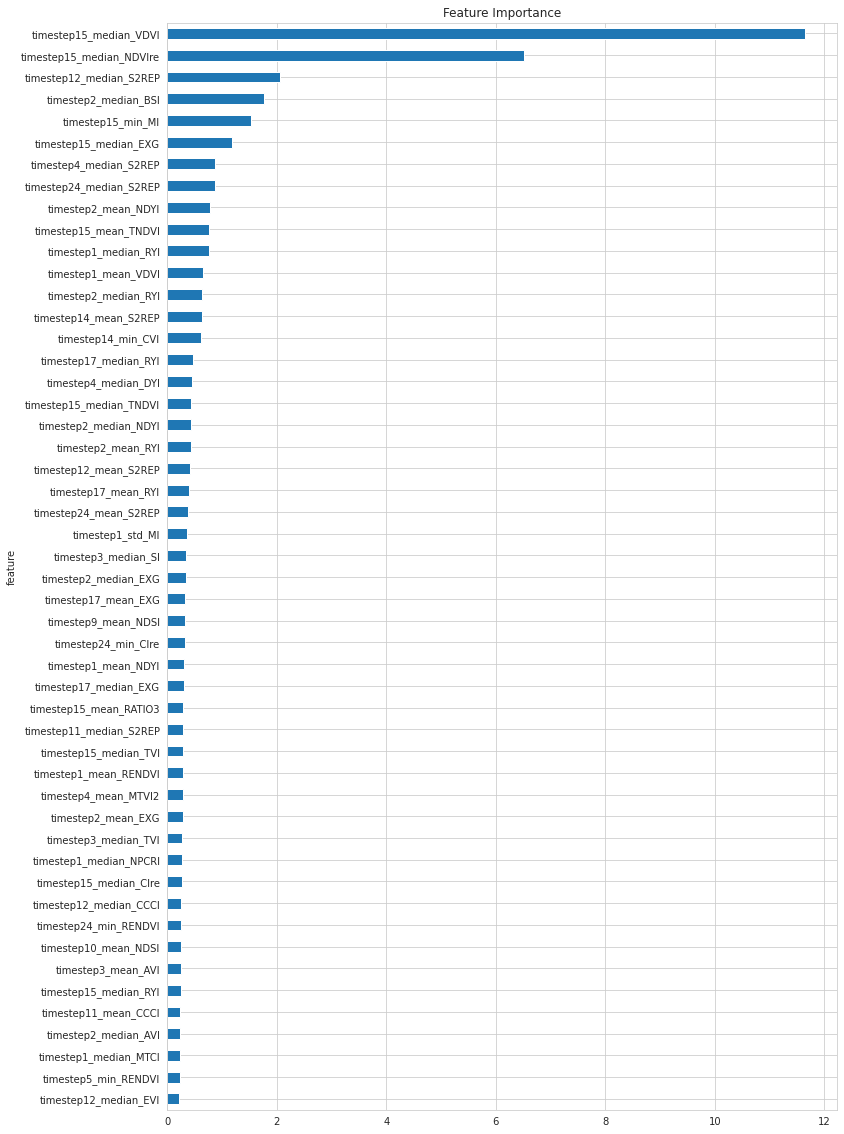

In [ ]:
# Feature Importance plot
sns.set_style('whitegrid')
fi = feature_importance_df.groupby('feature')['importance'].mean()
fi.sort_values(ascending=False)[:50][::-1].plot(kind = 'barh', figsize=(12, 20), title = 'Feature Importance')
plt.show()

In [ ]:
test_prediction = np.mean(season_predictions, 0)

In [ ]:
test_prediction.shape

(502, 13)

# SUBMISSION

---



In [ ]:

sub = pd.DataFrame(test_prediction)
sub = sub.rename(columns=Inversetarget_mapper)
sub['ID'] =  test['ID'].values
submission = pd.read_csv('/content/drive/MyDrive/GeoAI/SampleSubmission.csv')
submission = pd.merge(sub[['ID']],submission,on='ID',how='left')

for col in submission.columns[1:] :
  submission[col] = sub[col]
  
submission.head()

,ID,arable_soil,cereals,forage_crop,greenhouses,mixed_crops,ochards,olive,olive+arbo,olive+cereals,olive+crops,plowing_and_sowing,vegetable_and_flower,wheat
0,d8da32b5,0.135772,0.003506,0.009860,0.003454,0.009808,0.016040,0.700683,0.030209,0.063508,0.009436,0.002854,0.001910,0.012960
1,670ad0fb,0.055292,0.005328,0.010472,0.008700,0.042276,0.275081,0.364783,0.090596,0.052204,0.057956,0.010082,0.008429,0.018801
2,fec40ac9,0.013169,0.007254,0.006707,0.004988,0.030170,0.577781,0.136115,0.085560,0.029274,0.062561,0.006918,0.011792,0.027712
3,4f6d4495,0.011259,0.030533,0.050856,0.004198,0.046542,0.125113,0.200526,0.043728,0.326046,0.061017,0.005290,0.023573,0.071318
4,e56d2db7,0.327508,0.077219,0.085987,0.027032,0.032067,0.084556,0.111641,0.011512,0.079280,0.011040,0.101353,0.011325,0.039479


In [ ]:
submission.to_csv('submissiontestallidx.csv',index=False)